In [116]:
# COMP 4522 - Advanced Databases - Assignment 2
# Fall 2025
# Created by Seila, Kiera, Diesel, and James


#import statements
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [117]:
# connection to sqlite database

# SQLite only has the datatypes NULL, INTEGER, REAL (float), TEXT, and BLOB.
# Dates can use the SQLite builtin date functions, 
# see https://sqlite.org/lang_datefunc.html, or pandas to_datetime.

connection = sqlite3.connect("./Data/db2assign2.db")

In [118]:
# Execute SQL to create final tables with correct schema
cursor = connection.cursor()

cursor.execute("DROP TABLE IF EXISTS deptInfo;")
cursor.execute("DROP TABLE IF EXISTS employInfo;")
cursor.execute("DROP TABLE IF EXISTS studentCounselling;")
cursor.execute("DROP TABLE IF EXISTS studentPerformance;")

connection.commit()

# Note that a PRIMARY KEY in SQLite does not infer NOT NULL
# and an id (index) is required since we have duplicated primary keys
# in our dataset
cursor.execute('''
CREATE TABLE deptInfo (
    id INTEGER AUTO_INCREMENT NOT NULL,
    Department_ID STRING NOT NULL,
    Department_Name STRING,
    DOE STRING,
    PRIMARY KEY (id, Department_ID)
);
''')

cursor.execute('''
CREATE TABLE employInfo (
    id INTEGER AUTO_INCREMENT NOT NULL,
    Employee_ID STRING NOT NULL,
    DOB STRING,
    DOJ STRING,
    Department_ID STRING,
    FOREIGN KEY (Department_ID) REFERENCES deptInfo(Department_ID),
    PRIMARY KEY (id, Employee_ID)
);
''')

cursor.execute('''
CREATE TABLE studentCounselling (
    id INTEGER AUTO_INCREMENT NOT NULL,
    Student_ID STRING NOT NULL,
    DOA STRING NOT NULL,
    DOB STRING,
    Department_Choices STRING,
    Department_Admission STRING,
    FOREIGN KEY (Department_Choices) REFERENCES deptInfo(Department_ID),
    FOREIGN KEY (Department_Admission) REFERENCES deptInfo(Department_ID),
    PRIMARY KEY (id, Student_ID, DOA, Department_Choices)
);
''')

cursor.execute('''
CREATE TABLE studentPerformance (
    id INTEGER AUTO_INCREMENT NOT NULL,
    Student_ID STRING NOT NULL,
    Semster_Name STRING,
    Paper_ID STRING NOT NULL,
    Paper_Name STRING,
    Marks INTEGER,
    Effort_Hours INTEGER,
    FOREIGN KEY (Student_ID) REFERENCES studentCounselling(Student_ID),
    PRIMARY KEY (id, Student_ID, Paper_ID)
);
''')

connection.commit()

In [119]:
# Start by copying data from csv's into temporary tables

# Column names
dept_names = ["Department_ID", "Department_Name", "DOE"]
empl_names = ["Employee_ID", "DOB", "DOJ", "Department_ID"]
cncl_names = ["Student_ID", "DOA", "DOB", "Department_Choices", "Department_Admission"]
perf_names = ["Student_ID", "Semster_Name", "Paper_ID", "Paper_Name", "Marks", "Effort_Hours"]

# Change data types in SQLite, defaults to STRING
dept_dtype = {}
empl_dtype = {}
cncl_dtype = {}
perf_dtype = {"Marks": "INT", "Effort_Hours": "INT"}

# Read in csv data and add it to the SQLite database
pd.read_csv('./Data/Department_Information.csv', header=0, names=dept_names
           ).to_sql("deptInfo", connection, if_exists='append', index=True, index_label="id", dtype=dept_dtype)

pd.read_csv('./Data/Employee_Information.csv', header=0, names=empl_names
           ).to_sql("employInfo", connection, if_exists='append', index=True, index_label="id", dtype=empl_dtype)

pd.read_csv('./Data/Student_Counceling_Information.csv', header=0, names=cncl_names
           ).to_sql("studentCounselling", connection, if_exists='append', index=True, index_label="id", dtype=cncl_dtype)

pd.read_csv('./Data/Student_Performance_Data.csv', header=0, names=perf_names
           ).to_sql("studentPerformance", connection, if_exists='append', index=True, index_label="id", dtype=perf_dtype)

connection.commit()

In [120]:
# Get data for validation

dept_df = pd.read_sql_query("SELECT * FROM deptInfo", connection)
empl_df = pd.read_sql_query("SELECT * FROM employInfo", connection)
cncl_df = pd.read_sql_query("SELECT * FROM studentCounselling", connection)
perf_df = pd.read_sql_query("SELECT * FROM studentPerformance", connection)

#exceptions = {}

#def log_exception(df, name):
#    if not df.empty:
#        exceptions[name] = df
#        print(f"[!] {len(df)} issue(s) found in {name}")
#    else: 
#        print(f"[OK] {name} - no issues found")

#log_exception(df1, 'Department_ID')

In [121]:
# Cleaning and validating Department Information data

# Department_ID uniqueness
print(dept_df[dept_df.duplicated(subset=["Department_ID"], keep=False)])

# Department_Name uniqueness
print(dept_df[dept_df.duplicated(subset=["Department_Name"], keep=False)])

# Valid DOE and DOE > 1900
ref_date = pd.Timestamp("1900-01-01")
all_dates = pd.to_datetime(dept_df['DOE'], format="%m/%d/%Y", errors="coerce")
print(dept_df[all_dates.isna() | (all_dates < ref_date)])

# Missing values
print(dept_df[dept_df.isna().any(axis=1)])

    id Department_ID                                    Department_Name  \
1    1     IDEPT5528                     Biosciences and Bioengineering   
11  11     IDEPT1825                             Mechanical Engineering   
15  15     IDEPT3868          Center for Learning and Teaching (PPCCLT)   
21  21     IDEPT5528                      Sanitation and Digital Gaming   
24  24     IDEPT7005  Centre of Studies in Resources Engineering (CSRE)   
25  25     IDEPT7005      Centre of Studies in Craft Engineering (CSCE)   
27  27     IDEPT9009            Centre for the Study of Ecology in Mars   
35  35     IDEPT3868          Center for Learning and Teaching (PPCCLT)   
39  39     IDEPT9009                      Laser Technology Enhancements   
45  45     IDEPT1825                         Materials Strength Testing   

          DOE  
1   6/28/1943  
11  9/21/1971  
15  3/26/1982  
21       None  
24  8/22/1966  
25  8/22/1966  
27   7/9/2025  
35  3/26/1982  
39       None  
45  9/21/1971 

In [122]:
# Cleaning and validating Student Couselling data 

# Missing values
print(cncl_df[cncl_df.isna().any(axis=1)])

# Department_Admission does not exist in dept_df
non_empty_dept = cncl_df.dropna(subset=["Department_Admission"])
print(non_empty_dept[~non_empty_dept['Department_Admission'].isin(dept_df['Department_ID'])])


      id   Student_ID       DOA        DOB Department_Choices  \
298  298  SID20135073  7/1/2013  12/7/1995               None   

    Department_Admission  
298                 None  
Empty DataFrame
Columns: [id, Student_ID, DOA, DOB, Department_Choices, Department_Admission]
Index: []


In [123]:
# Cleaning and validating studentPerformance data

# we start with an unclean/unvalidated data frame, we continually keep re cleaning based off
# of different columns, and removing those rows of data as needed
# we are printing the exception reports from the original dataframe in order to capture all incorrect/invalid data

perf_clean_df = None

# Marks between 0-100
perf_clean_df = perf_df.query('0 <= Marks <= 100')
print(perf_df.query('Marks < 0 | Marks > 100'))

# Effort_Hours > 0
perf_clean_df = perf_clean_df.query('0 <= Effort_Hours')
print(perf_df.query('Effort_Hours < 0'))

# Duplicate mark entries for a student and a paper
print(perf_df[perf_df.duplicated(subset=["Student_ID", "Paper_ID"], keep=False)])

# Missing values
perf_clean_df = perf_clean_df.dropna()
print(perf_df[perf_df.isna().any(axis=1)])


            id   Student_ID Semster_Name     Paper_ID Paper_Name  Marks  \
328        328  SID20131189        Sem_1  SEMI0015910    Paper 4  -49.0   
414        414  SID20131191        Sem_5  SEMI0055015    Paper 6  207.0   
551        551  SID20131231        Sem_1  SEMI0016208    Paper 5 -100.0   
840        840  SID20131303        Sem_3  SEMI0031818    Paper 4  140.0   
181488  181488  SID20182774        Sem_8  SEMI0086600    Paper 6  999.0   

        Effort_Hours  
328              0.0  
414             14.0  
551             14.0  
840             14.0  
181488           5.0  
          id   Student_ID Semster_Name     Paper_ID Paper_Name  Marks  \
59635  59635  SID20147406        Sem_6  SEMI0067259    Paper 2   78.0   

       Effort_Hours  
59635          -3.0  
Empty DataFrame
Columns: [id, Student_ID, Semster_Name, Paper_ID, Paper_Name, Marks, Effort_Hours]
Index: []
            id   Student_ID Semster_Name     Paper_ID Paper_Name  Marks  \
125        125  SID20131171        S

In [124]:
# Join cleaned Student performance to counseling to department info for future data mining

master_df = pd.merge(perf_clean_df, cncl_df, on='Student_ID', suffixes=["_perf", "_cncl"])

# Rename dept_df index column to match index column format in first merge
pre_merge_dept_df = dept_df.rename(columns={"index": "index_dept"})

master_df = pd.merge(master_df, pre_merge_dept_df, left_on='Department_Admission', right_on='Department_ID')

In [125]:
# We have to run predictive analysis on these three students, ideally using a clean dataset
effort_marks_df = master_df[["Effort_Hours", "Marks"]]

df_student1 = master_df.query("Student_ID == 'SID20131151'")
df_student2 = master_df.query("Student_ID == 'SID20149500'")
df_student3 = master_df.query("Student_ID == 'SID20182516'")

<Axes: title={'center': 'Plot of Effort/Mark achieved'}, xlabel='Effort_Hours', ylabel='Marks'>

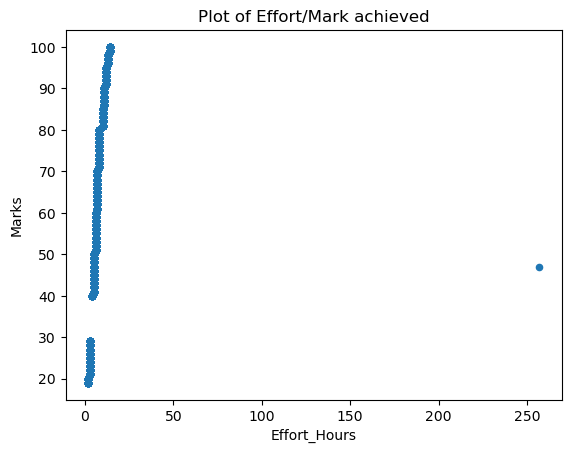

In [126]:
effort_marks_df.plot.scatter(x='Effort_Hours', y='Marks', title='Plot of Effort/Mark achieved')

In [127]:
# anything above 0.8 is considered 'high' according to LinRegmin
# we can use this loop to test any two column dataframe for correlations
corrTest = effort_marks_df.corr()
for col1 in corrTest.columns:
    for col2 in corrTest.columns:
        if col1 != col2 and abs(corrTest.loc[col1, col2]) > 0.8:
            print(f"{col1} vs {col2}: {corrTest.loc[col1, col2]:.3f}")

Effort_Hours vs Marks: 0.949
Marks vs Effort_Hours: 0.949


In [128]:
# This takes a dataframe with numerical entries and groups them together
# SHOULD work with multiple columns?
def print_correlations(dataf, threshold):
    corr_test = dataf.corr(numeric_only=True)
    checked = set()

    for col1 in corr_test.columns:
        for col2 in corr_test.columns:
            if col1 != col2 and (col2, col1) not in checked:
                correlation = corr_test.loc[col1, col2]
                if abs(correlation) > threshold:
                    print(f"[{col1}:{col2}:{correlation:.3f}]")
                checked.add((col1, col2))
print(print_correlations(effort_marks_df, 0.8))

[Effort_Hours:Marks:0.949]
None


In [129]:
#take a dataframe with two columns, split them, run linear regression, predict and/or plot things
def lin_reg(dataf, xcol, ycol, predict=None, plot=True):
    dataf = dataf.dropna() # drops NaN entries
    # col1, col2 = dataf.columns
    y=dataf[ycol].values.reshape(-1,1)
    # print(y.shape) # Testing
    x=dataf[xcol].values.reshape(-1,1)
    # print(x.shape) # Testing
    x_train, x_test, y_train, y_test = train_test_split(x ,y, test_size=0.2, random_state=42)
    regressor=LinearRegression()
    regressor.fit(x_train, y_train)
    if predict is not None:
        predict = np.array(predict).reshape(-1,1)
        predicted_y = regressor.predict(predict)
        print("Predictions:")
        for i, val in enumerate(predict.flatten()):
            print(f"Supplied {xcol} = {val:.2f} \nPredicted {ycol} = {predicted_y[i][0]:.2f}%")
    if plot:
        plt.scatter(x, y)
        plt.plot(x, regressor.predict(x), color='red')
        if predict is not None:
            plt.scatter(predict, predicted_y, color='lime', marker='^', s=220)
        plt.title(f"Linear Regression: {ycol} vs {xcol}")
        plt.xlabel(xcol)
        plt.ylabel(ycol)
        
    print(f"Accuracy: {regressor.score(x_test, y_test)*100:.2f}%")

Predictions:
Supplied Effort_Hours = 10.00 
Predicted Marks = 81.99%
Accuracy: 95.61%


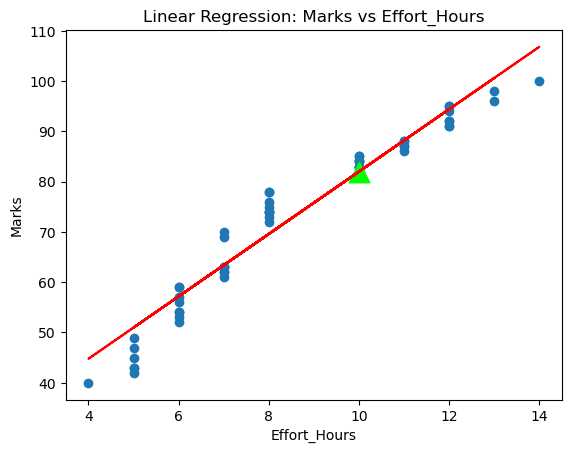

In [130]:
lin_reg(df_student1, 'Effort_Hours', 'Marks', 10, True)

Predictions:
Supplied Effort_Hours = 10.00 
Predicted Marks = 83.99%
Accuracy: 90.56%


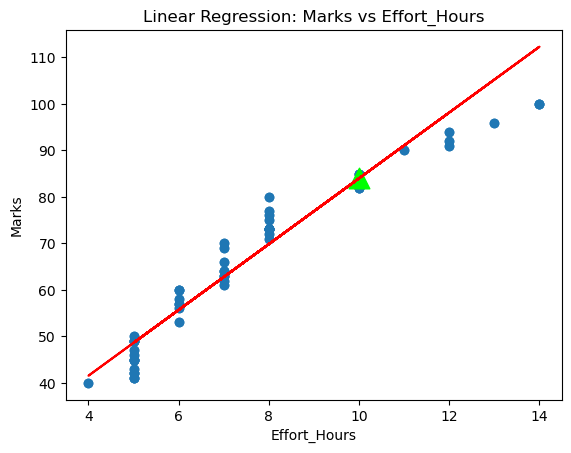

In [131]:
lin_reg(df_student2, 'Effort_Hours', 'Marks', 10, True)

Predictions:
Supplied Effort_Hours = 10.00 
Predicted Marks = 82.40%
Accuracy: 93.80%


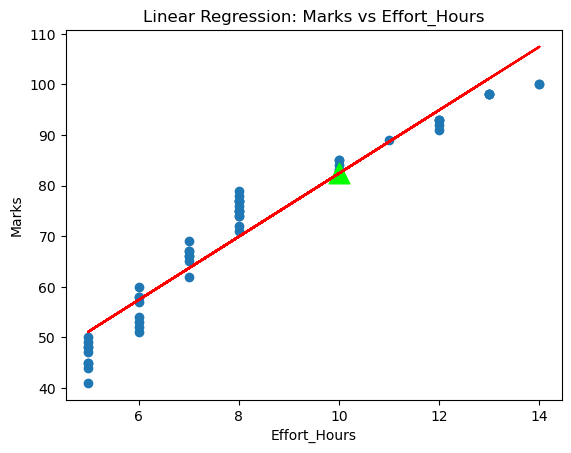

In [132]:
lin_reg(df_student3, 'Effort_Hours', 'Marks', 10, True)

In [133]:
connection.close()